# Standardized CCM Workflow Vignette

This script demonstrates the complete workflow for convergent cross mapping
analysis using the edmsystems package. It shows how to:

1. Generate test data with known ground truth
2. Run CCM analysis with parameter optimization
3. Test significance using surrogate methods
4. Compare detected network to ground truth
5. Visualize results

This workflow provides a standardized, reproducible approach for causal
inference in dynamical systems.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
import seaborn as sns

from edmsystems.testdata import make_test_dataframe, get_ground_truth_network
from edmsystems.ccm import run_ccm_workflow, test_ccm_pair
from edmsystems.ccm.analysis import compare_to_ground_truth, compute_performance_metrics, summarize_results

In [2]:
# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

In [3]:
# Number of jobs
n_jobs = mp.cpu_count() // 4
print("Number of jobs: " + str(n_jobs))

Number of jobs: 32


## STEP 1: Generate test data with known ground truth

In [4]:
# Generate 500 time points of test data with datetime
df = make_test_dataframe(n=500, seed=42, start_date='2000-01-01', freq='D')

print(f"Generated dataframe with {len(df)} time points")
print(f"Columns: {list(df.columns)}")
print()

# Get ground truth network
truth_network = get_ground_truth_network()

print("Ground truth causal edges:")
true_edges = []
for driver in truth_network.index:
    for target in truth_network.columns:
        if truth_network.loc[driver, target] == 1:
            true_edges.append(f"  {driver} -> {target}")

for edge in true_edges:
    print(edge)

print(f"\nTotal true edges: {len(true_edges)}")

Generated dataframe with 500 time points
Columns: ['datetime', 'independent_X', 'independent_Y', 'correlated_X', 'correlated_Y', 'lagcorr_X', 'lagcorr_Y', 'crosscorr_X', 'crosscorr_Y', 'autocorr_X', 'autocorr_Y', 'seasonal_sync_X', 'seasonal_sync_Y', 'seasonal_lag_X', 'seasonal_lag_Y', 'unidirectional_X', 'unidirectional_Y', 'bidirectional_X', 'bidirectional_Y', 'weak_X', 'weak_Y']

Ground truth causal edges:
  unidirectional_X -> unidirectional_Y
  bidirectional_X -> bidirectional_Y
  bidirectional_Y -> bidirectional_X
  weak_X -> weak_Y

Total true edges: 4


## STEP 2: Example - Test a single pair with full workflow

In [5]:
# Test unidirectional causal pair
X = df['unidirectional_X'].values
Y = df['unidirectional_Y'].values

result = test_ccm_pair(
    X, Y,
    driver_name='unidirectional_X',
    target_name='unidirectional_Y',
    libSizes="50 500 50",  # Reduced for faster demo
    sample=50,              # Reduced for faster demo
    n_surrogates=19,        # Reduced for faster demo
    surrogate_method='twin',
    optimize_params=True,
    optimize_theta=False,
    seed=42,
    verbose=True
)

print("\nResult summary:")
print(f"  Parameters: tau={result['tau']}, E={result['E']}, Tp={result['Tp']}")
print(f"  Rho (max lib): {result['rho_original']:.3f}")
print(f"  Rho (surrogates): {result['rho_surrogate_mean_twin']:.3f} ± {result['rho_surrogate_std_twin']:.3f}")
print(f"  p-value: {result['p_value_twin']:.4f}")
print(f"  Significant: {result['is_significant_twin']}")
print(f"  Convergent: {result['convergent']}")


Testing: unidirectional_X -> unidirectional_Y

Optimizing parameters...
PARAMETER OPTIMIZATION

Step 1: Finding optimal tau from ACF...
  → tau = 3 (ACF = 0.057)

Step 2: Finding optimal E from target reconstruction...
  → E = 2 (rho = 0.935)

Step 3: Finding optimal Tp from cross-mapping...
  → Tp = -1 (rho = 0.307)



Computing original CCM (libSizes=50 500 50, sample=50)...
  LibSize 50: ✓
  LibSize 100: ✓
  LibSize 150: ✓
  LibSize 200: ✓
  LibSize 250: ✓
  LibSize 300: ✓
  LibSize 350: ✓
  LibSize 400: ✓
  LibSize 450: ✓
  LibSize 500: ✓
  Original rho (max lib): 0.307
  Convergent: True

Generating 19 'twin' surrogates...
  Surrogate rho: 0.039 ± 0.051
  95th percentile: 0.117
  99th percentile: 0.139
  p-value: 0.0500
  Significant: False

Result summary:
  Parameters: tau=3, E=2, Tp=-1
  Rho (max lib): 0.307
  Rho (surrogates): 0.039 ± 0.051
  p-value: 0.0500
  Significant: False
  Convergent: True


## STEP 3: Run workflow on selected pairs

In [7]:
# Select a subset of pairs for demonstration
# In practice, you could test all pairs or specify custom pairs
test_pairs = [
    # True causal (should be detected)
    ('unidirectional_X', 'unidirectional_Y'),
    ('bidirectional_X', 'bidirectional_Y'),
    ('bidirectional_Y', 'bidirectional_X'),
    ('weak_X', 'weak_Y'),

    # Non-causal (should NOT be detected)
    ('independent_X', 'independent_Y'),
    ('correlated_X', 'correlated_Y'),
    ('autocorr_X', 'autocorr_Y'),
    ('seasonal_sync_X', 'seasonal_sync_Y'),
]

print(f"Testing {len(test_pairs)} pairs...")
print()

# Run workflow
results = run_ccm_workflow(
    df,
    pairs=test_pairs,
    datetime_col='datetime',
    libSizes="50 500 50",
    sample=50,
    n_surrogates=19,
    surrogate_method='twin',
    optimize_params=True,
    optimize_theta=False,
    exclusionRadius=0,
    n_jobs=n_jobs,            # Parallel across pairs (use all cores)
    seed=42,
    verbose=False,        # Quiet mode
)

print("\nResults:")
print(results[['driver', 'target', 'tau', 'E', 'Tp', 'rho_original',
               'p_value_twin', 'is_significant_twin', 'convergent']])

Testing 8 pairs...


Results:
             driver            target  tau  E  Tp  rho_original  p_value_twin  \
0  unidirectional_X  unidirectional_Y    3  2  -1      0.307049          0.05   
1   bidirectional_X   bidirectional_Y    3  2  -1      0.308006          0.05   
2   bidirectional_Y   bidirectional_X    3  2  -1      0.356367          0.05   
3            weak_X            weak_Y    3  2  -2      0.226674          0.05   
4     independent_X     independent_Y    1  3  -1      0.073259          0.20   
5      correlated_X      correlated_Y    1  3   0      0.719482          0.60   
6        autocorr_X        autocorr_Y   12  7   0      0.000084          0.45   
7   seasonal_sync_X   seasonal_sync_Y    6  5  -3      0.901428          0.05   

   is_significant_twin  convergent  
0                False        True  
1                False       False  
2                False        True  
3                False        True  
4                False        True  
5                F

## STEP 4: Compare to ground truth

In [8]:
# Summarize results with ground truth comparison
summary = summarize_results(results, truth_network, print_summary=True)

# Get detailed comparison
comparison = compare_to_ground_truth(results, truth_network)

print("\nDetailed classifications:")
print(comparison[['driver', 'target', 'detected', 'true_edge', 'classification']])

# Show false positives
fp = comparison[comparison['classification'] == 'FP']
if len(fp) > 0:
    print("\nFalse positives (incorrectly detected as causal):")
    for _, row in fp.iterrows():
        print(f"  {row['driver']} -> {row['target']}")
else:
    print("\nNo false positives!")

# Show false negatives
fn = comparison[comparison['classification'] == 'FN']
if len(fn) > 0:
    print("\nFalse negatives (missed true causal edges):")
    for _, row in fn.iterrows():
        print(f"  {row['driver']} -> {row['target']}")
else:
    print("\nNo false negatives!")


CCM RESULTS SUMMARY
Surrogate method: twin
Pairs tested: 8
Significant results (p < 0.01): 0 (0.0%)
Convergent results: 7 (87.5%)
Mean rho (original): 0.362

----------------------------------------------------------------------
PERFORMANCE vs GROUND TRUTH
----------------------------------------------------------------------
True Positives:  0
False Positives: 0
True Negatives:  4
False Negatives: 4

Precision: 0.000
Recall:    0.000
F1 Score:  0.000
Accuracy:  0.500
MCC:       0.000


Detailed classifications:
             driver            target  detected  true_edge classification
0  unidirectional_X  unidirectional_Y     False       True             FN
1   bidirectional_X   bidirectional_Y     False       True             FN
2   bidirectional_Y   bidirectional_X     False       True             FN
3            weak_X            weak_Y     False       True             FN
4     independent_X     independent_Y     False      False             TN
5      correlated_X      correlated_Y

## STEP 5: Visualize results

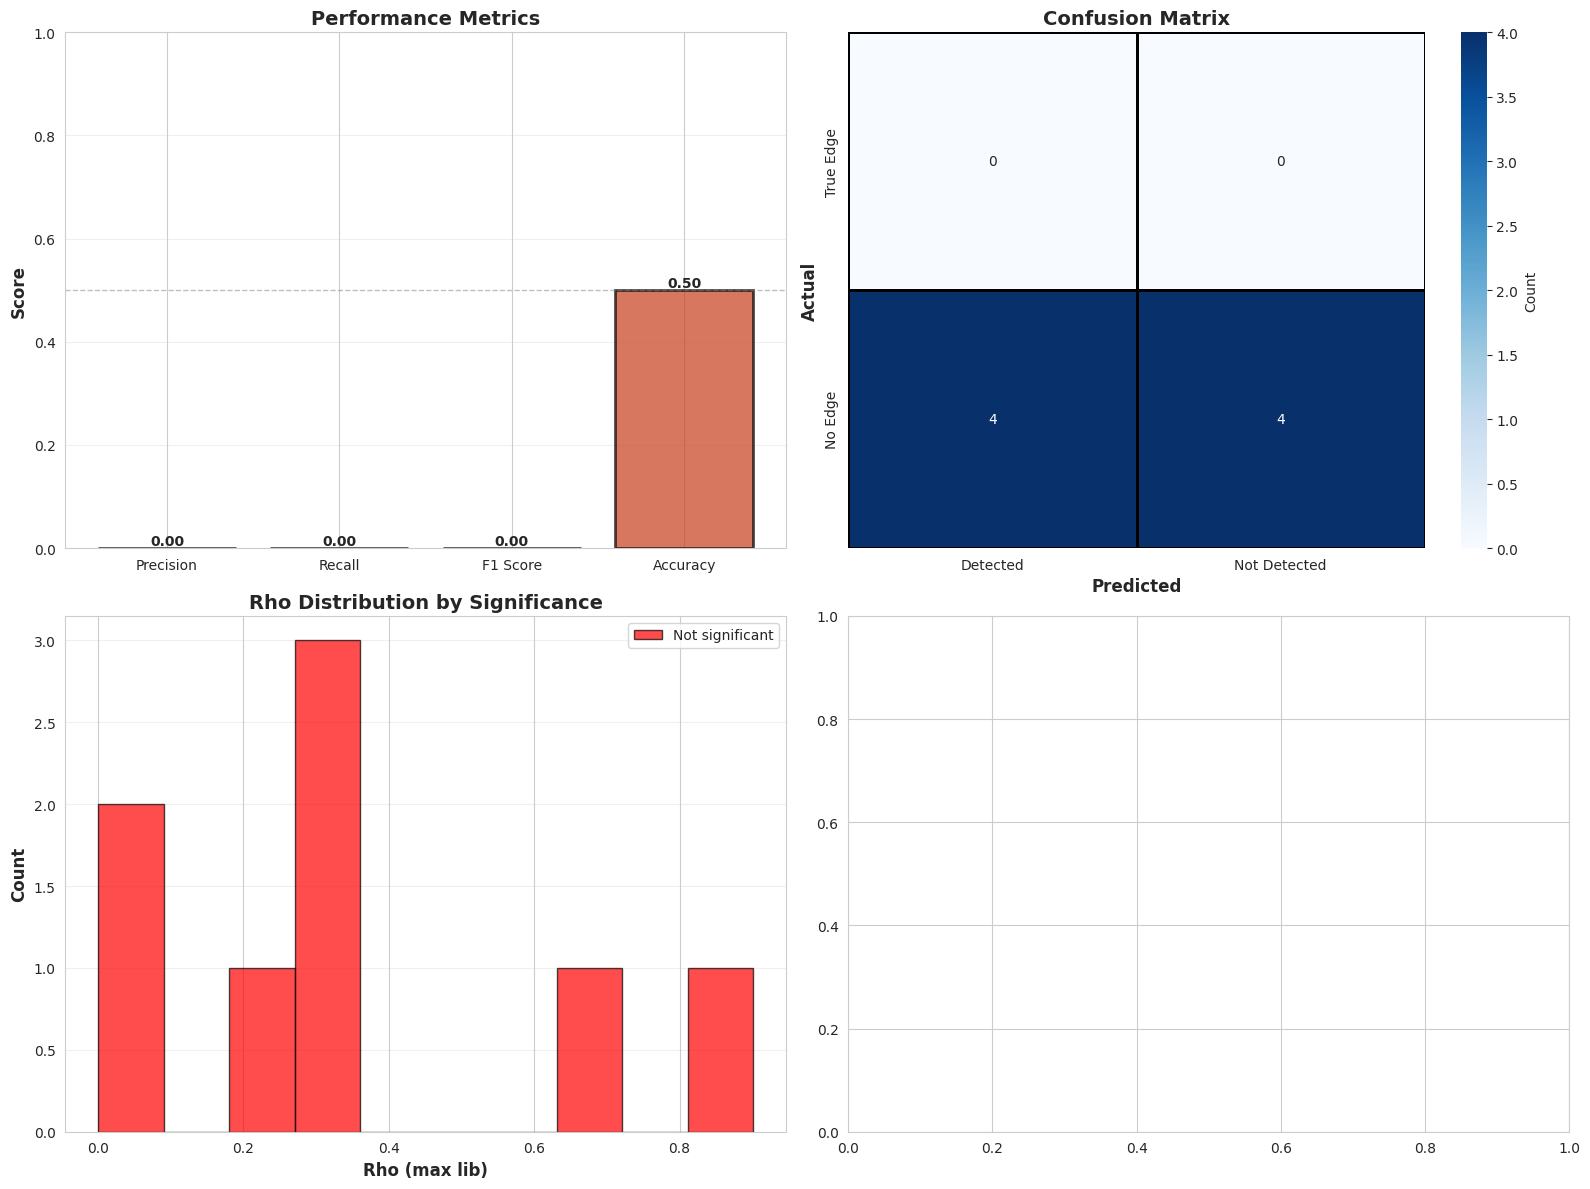

Exception ignored in: <function ResourceTracker.__del__ at 0x7f7ce5e21f80>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f4f58cadf80>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/usr/lib64/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f70bf371f80>
Traceback (most recent call last):
  File "/usr/lib64/python3.12/multip

In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Panel A: Performance metrics
ax = axes[0, 0]
metrics = summary['performance_metrics']
metric_names = ['Precision', 'Recall', 'F1 Score', 'Accuracy']
metric_values = [metrics['precision'], metrics['recall'],
                metrics['f1_score'], metrics['accuracy']]
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']
bars = ax.bar(metric_names, metric_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylim([0, 1])
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Performance Metrics', fontsize=14, fontweight='bold')
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.2f}',
            ha='center', va='bottom', fontweight='bold')

# Panel B: Confusion matrix
ax = axes[0, 1]
confusion = np.array([[metrics['TP'], metrics['FP']],
                     [metrics['FN'], metrics['TN']]])
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Detected', 'Not Detected'],
            yticklabels=['True Edge', 'No Edge'],
            cbar_kws={'label': 'Count'},
            ax=ax, vmin=0, linewidths=2, linecolor='black')
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax.set_ylabel('Actual', fontsize=12, fontweight='bold')

# Panel C: Rho distribution (detected vs non-detected)
ax = axes[1, 0]
detected = results[results['is_significant_twin']]['rho_original'].values
not_detected = results[~results['is_significant_twin']]['rho_original'].values

if len(detected) > 0:
    ax.hist(detected, bins=10, alpha=0.7, label='Significant',
            color='green', edgecolor='black')
if len(not_detected) > 0:
    ax.hist(not_detected, bins=10, alpha=0.7, label='Not significant',
            color='red', edgecolor='black')

ax.set_xlabel('Rho (max lib)', fontsize=12, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')
ax.set_title('Rho Distribution by Significance', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')


plt.tight_layout()
plt.show()